In [3]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2

In [4]:
file_path = 'plasma_membrane_dendrite_cropped.tif'

In [5]:
image = tifffile.imread(file_path)

In [6]:
# Function to display the image
def display_image(image, p=False):

    # Print the image shape
    if p:
        print(f"Image shape: {image.shape}")
        print(image)

    # Ensure the image tensor is in the range [0, 1]
    # image_normalized = image / 255.0

    # Display the image
    plt.imshow(image, cmap='gray')
    plt.axis('off')  # Turn off axis numbers
    plt.show()

Image shape: (849, 1411)
[[139 139 139 ... 143 133 144]
 [139 139 139 ... 147 144 141]
 [139 139 139 ... 137 144 141]
 ...
 [139 139 139 ... 139 139 139]
 [139 139 139 ... 139 139 139]
 [139 139 139 ... 139 139 139]]


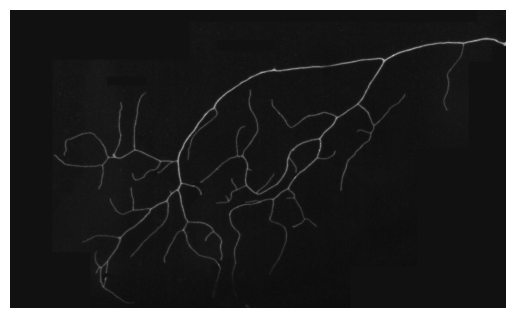

In [13]:
display_image(image, True)

In [8]:
print(image.dtype)    # <----- IMPORTANT! 16-bit image

uint16


**Assumptions and Notes**
* Because this images shows neuronal dendrites, I assume this a tree structure with no cycles. Therefore, I can use a depth first search approach.
* We also assume we can start with the 'Cell Body', which is the root of the tree structure.

In [9]:
# DFS Algorithm Code

class TreeNode:
    def __init__(self, id):
        self.id = id
        self.children = []

    # for creating synthetic data
    def add_child(self, child_node):
        self.children.append(child_node)

def countLeaves(node):
    # Base case: if the node is None, return 0
    if not node:
        return 0

    # Base case: if the node is a leaf (no children), return 1
    if not node.children:
        return 1

    # Recursive case: count leaves in all subtrees of the current node
    leaf_count = 0
    for child in node.children:
        leaf_count += countLeaves(child)

    # Print the current node and its leaf count
    print(f"Node {node.id} has {leaf_count} leaves")

    return leaf_count


In [10]:
# Generate synthetic data
root = TreeNode("root")
child1 = TreeNode("child1")
child2 = TreeNode("child2")
leaf1 = TreeNode("leaf1")
leaf2 = TreeNode("leaf2")
leaf3 = TreeNode("leaf3")

root.add_child(child1)
root.add_child(child2)
child1.add_child(leaf1)
child1.add_child(leaf2)
child2.add_child(leaf3)

total_leaves = countLeaves(root)


Node child1 has 2 leaves
Node child2 has 1 leaves
Node root has 3 leaves


### Now the question becomes how should we get the 'relationship' data among those joint points in the image.

### Step 1 - Segment the image

**a few approaches mind**

* Deep learning based segmentation (pret-trained vision model or cnn) - pixel level accuracy is important.
* Manual approach - enhance the image, get edges, find joint points and leaf nodes and create a graph - pixel level accuracy is ALSO IMPORTANT



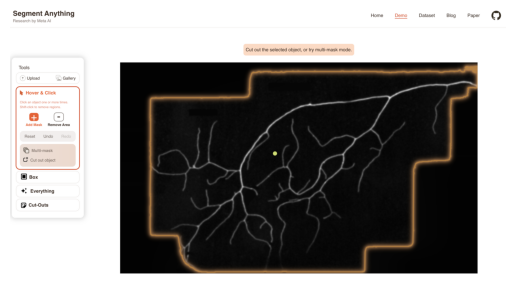

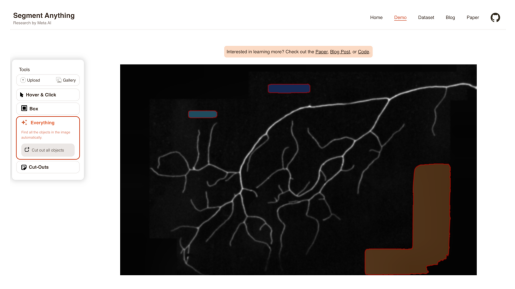

In [16]:
# Try a pre-trained vision model - SAM


# Segment Anything Model seems not to work - it can't detect the "edges"
# However, some finetuning using our private data could result in better performance.

i1 = cv2.imread('i1.png')
i2 = cv2.imread('i2.png')

display_image(i1)
display_image(i2)


Image shape: (849, 1411)
[[139 139 139 ... 143 142 141]
 [139 139 139 ... 142 142 142]
 [139 139 139 ... 141 142 143]
 ...
 [139 139 139 ... 139 139 139]
 [139 139 139 ... 139 139 139]
 [139 139 139 ... 139 139 139]]


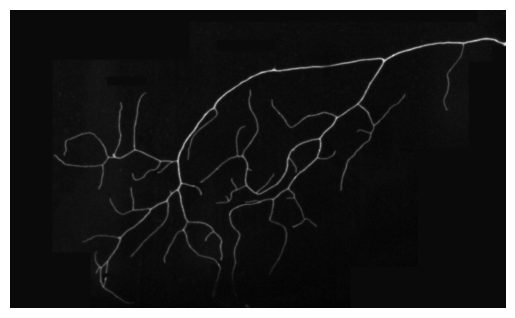

Image shape: (849, 1411)
[[11 11 11 ... 14 13 12]
 [11 11 11 ... 13 13 13]
 [11 11 11 ... 12 13 14]
 ...
 [11 11 11 ... 11 11 11]
 [11 11 11 ... 11 11 11]
 [11 11 11 ... 11 11 11]]


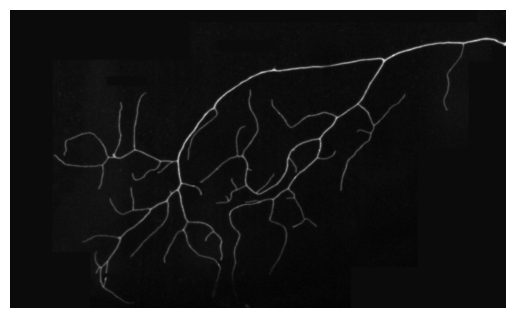

Image shape: (849, 1411)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


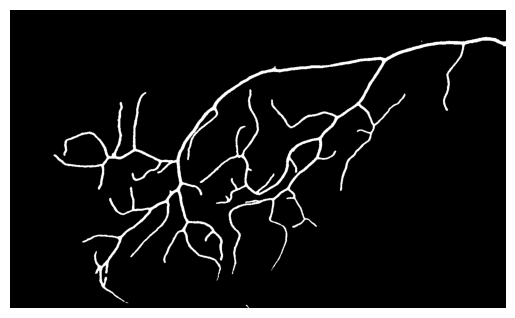

In [17]:
# IMPLEMENTATION OF MANUAL APPROACH

# for noise reduction
smoothed_image = cv2.GaussianBlur(image, (5, 5), 0)
display_image(smoothed_image, True)

# # Enhance contrast using CLAHE, histogram equalization technique
# # I set clipLimit to 2.0 to limit the amplification effects
# clahe = cv2.createCLAHE(clipLimit=2.0)
# contrasted_image = clahe.apply(smoothed_image)

# display_image(contrasted_image, True)

# Normalize the image.
# This step converts a 16-bit image to a 8-bit image    <----- This could lead to loss of information
normalized_image = cv2.normalize(smoothed_image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
display_image(normalized_image, True)

THRESHOLD_VALUE = 30 # <----- This is based on experiential expereiments results

_, segmented_image = cv2.threshold(normalized_image, THRESHOLD_VALUE, 255, cv2.THRESH_BINARY)
display_image(segmented_image, True)



### Step 2 - Get the skeleton

In [18]:
binary_segmented_image = segmented_image > 0

In [19]:
binary_segmented_image.max()

True

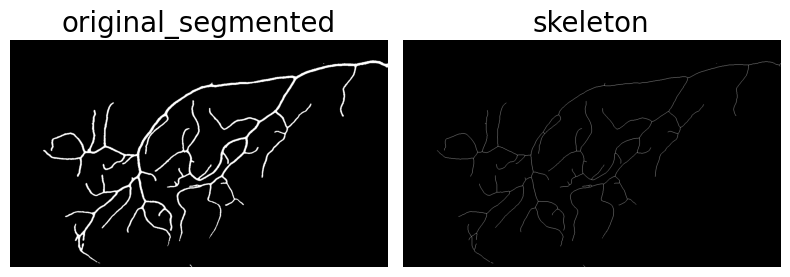

In [20]:
# Get the skeleton using skimage package
# code source: https://scikit-image.org/docs/stable/auto_examples/edges/plot_skeleton.html

# we turned it into a 1 pixel wide skeleton

from skimage.morphology import skeletonize
from skimage import data
import matplotlib.pyplot as plt


# perform skeletonization
skeleton = skeletonize(binary_segmented_image)

# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(binary_segmented_image, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original_segmented', fontsize=20)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)

fig.tight_layout()
plt.show()

Image shape: (849, 1411)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


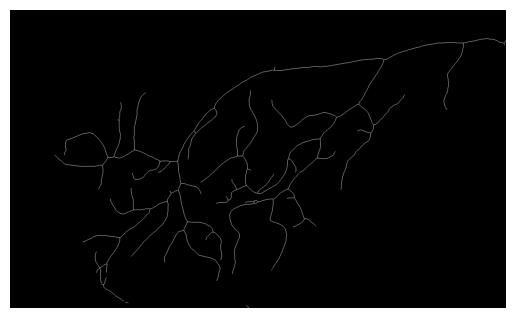

In [21]:
display_image(skeleton, True)

#### Note that: the joints are pixels surrounded by three or four neighbors, while the edges pixels have only two. Free endpoints have only one, which are leaf nodes in our case.

In [22]:
def find_neighbors(loc, skeleton): # loc is a tuple here
  neighbors = []
  # check all sournding pixels and skip itself
  for i in range(-1, 2):
    for j in range(-1, 2):
      if i == 0 and j == 0:
        continue
      r, c = loc[0] + i, loc[1] + j
      # make sure they are inside the skeleton
      if 0 <= r < skeleton.shape[0] and 0 <= c < skeleton.shape[1]:
        if skeleton[r, c]:
          neighbors.append((r, c))
  return neighbors


In [23]:
def is_junction(loc, skeleton):
  return len(find_neighbors(loc, skeleton)) > 2

def is_leaf(loc, skeleton):
  return len(find_neighbors(loc, skeleton)) == 1

In [24]:
def traverse_nodes(skeleton):
  junctions = []
  leaf_nodes = []
  for r in range(skeleton.shape[0]):
    for c in range(skeleton.shape[1]):
      if skeleton[r, c]:
        if is_junction((r, c), skeleton):
          junctions.append((r, c))
        elif is_leaf((r, c), skeleton):
          leaf_nodes.append((r, c))
  return junctions, leaf_nodes

In [25]:
junctions, leaf_nodes = traverse_nodes(skeleton)
print(len(junctions))

162


In [26]:
from google.colab.patches import cv2_imshow

def mark_nodes_on_skeleton(skeleton, nodes): # could be either leaf nodes or junctions

    # Ensure skeleton is in the right format (255 for lines, 0 for background)
    marked_img = (skeleton * 255).astype('uint8')

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    font_color = 255  # White color for binary image
    font_thickness = 1

    for i, point in enumerate(nodes):
        cv2.putText(marked_img, str(i), (point[1], point[0]), font, font_scale, font_color, font_thickness, cv2.LINE_AA)

    # Display the image
    cv2_imshow(marked_img)

    return marked_img

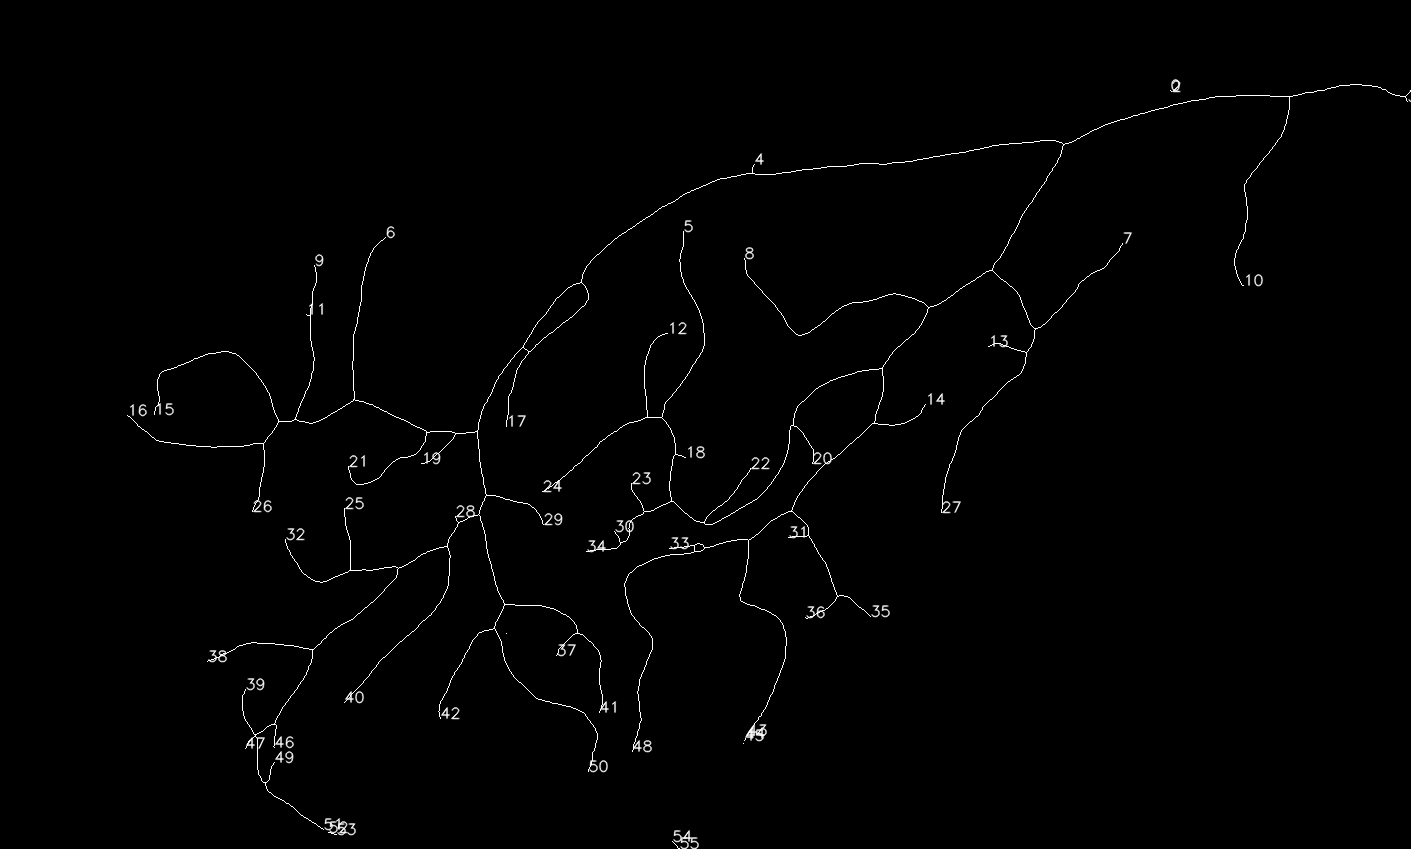

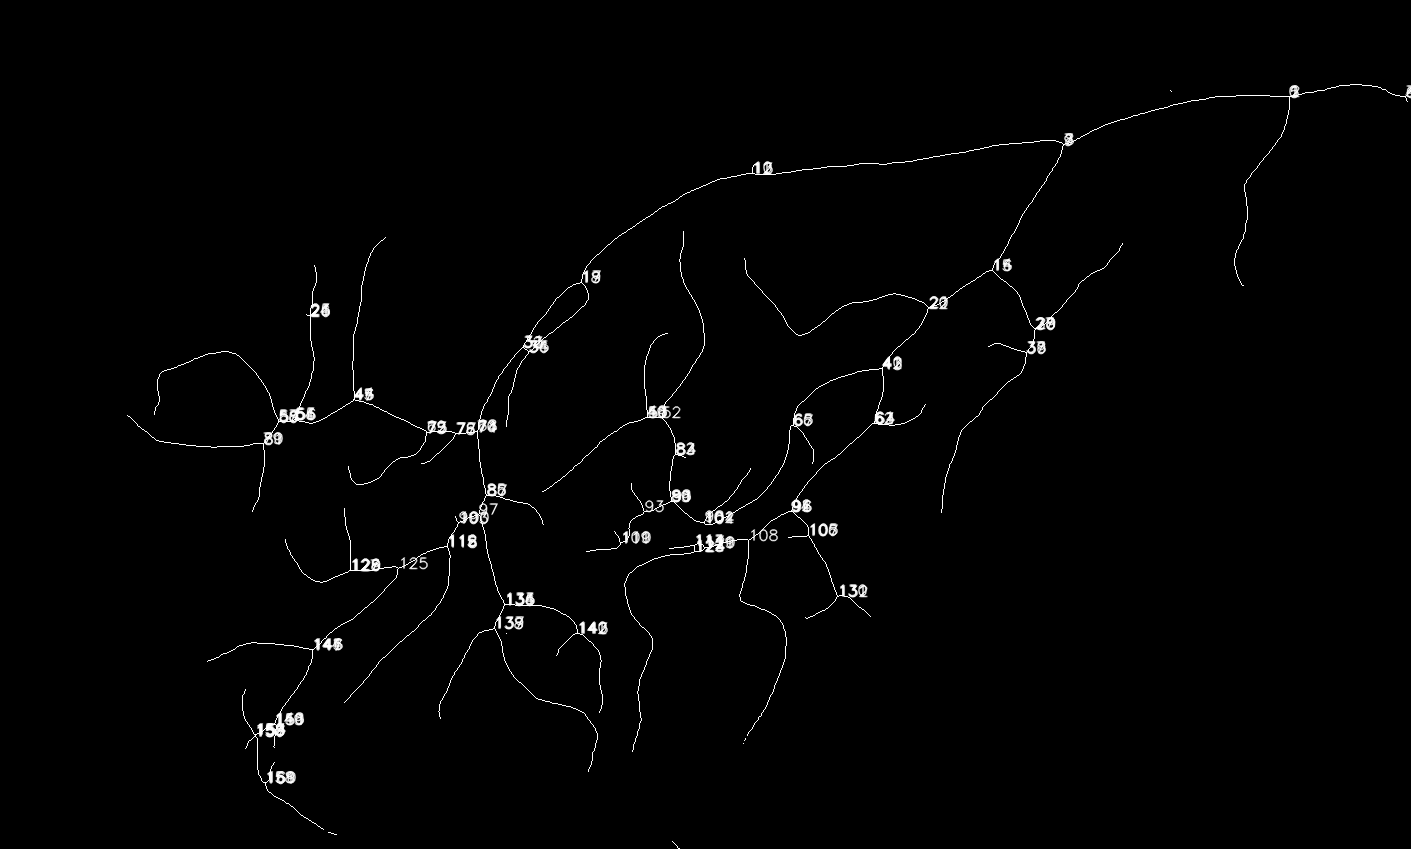

In [27]:
# Showing marked leaf nodes here is only for inspection purposes

marked_leaf_nodes_image = mark_nodes_on_skeleton(skeleton, leaf_nodes)
marked_junctions_image = mark_nodes_on_skeleton(skeleton, junctions)


#### There are still some errors in marking leaf nodes, and it doesn't achieve 100% accuracy, at least based on inspection using human eyes. The junction nodes detection seem to have a worse performance, and there are so many duplicates as showed in the graph. However, it's a positive sign that we can create a graph (a simple tree here) given the results.

**Also, note that the code provided at the beginning of the notebook assumes the input is a simple tree structure. However, given the results after image preprocessing, there could be cycles in the structure, so we need to handle this by treating it as a graph for robustness.**

#### To solve the issue that many junctions packed together, which mostly likely are not due to the original biological structure, we can leverage an unsupervised machine learning algorithm to cluster neayby junctions into one.

In [28]:
from sklearn.cluster import DBSCAN
import random
random.seed(1)
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

# The maximum distance between two samples for them to be considered as in the same neighborhood.
# Considering that each pixel represents 162 nm in length
EPS = 2 # RADIUS

# Also could be used for leaf nodes
# we could adjust how we would like the clustered points to be created - random or centre
def cluster_nodes( nodes, eps=EPS, min_samples=1, random_choice=False):

    if not nodes:
        return []

    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(nodes)

    if random_choice:
      clustered_nodes = []
      for cluster_id in set(clustering.labels_):
          # Extract points that belong to the current cluster
          points = np.array(nodes)[clustering.labels_ == cluster_id]
          # Choose a random point from the cluster
          random_point = tuple(map(int, random.choice(points))) # shows location
          clustered_nodes.append(random_point)
      return clustered_nodes


    cluster_centers = []
    for cluster_id in set(clustering.labels_):
          points = np.array(nodes)[clustering.labels_ == cluster_id]
          centroid = np.mean(points, axis=0)
          cluster_centers.append(tuple(map(int, centroid)))

    return cluster_centers

In [29]:
clustered_junctions = cluster_nodes(junctions, eps=EPS, min_samples=1, random_choice=True)
clustered_leaf_nodes = cluster_nodes(leaf_nodes, eps=EPS, min_samples=1, random_choice=True)

print("Num of junctions: ", len(clustered_junctions))
print("Num of leaf nodes: ", len(clustered_leaf_nodes))

Num of junctions:  49
Num of leaf nodes:  55


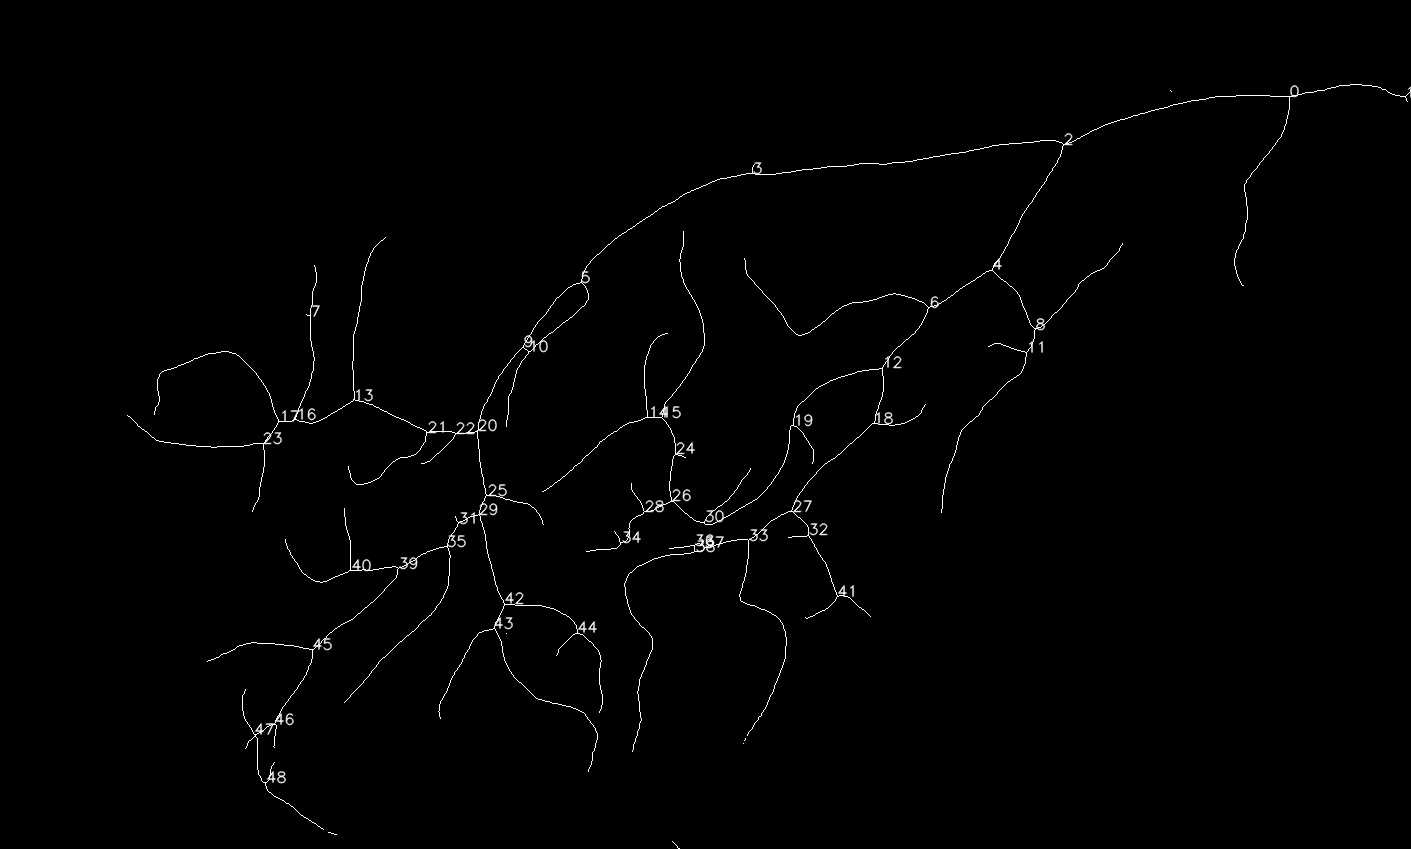

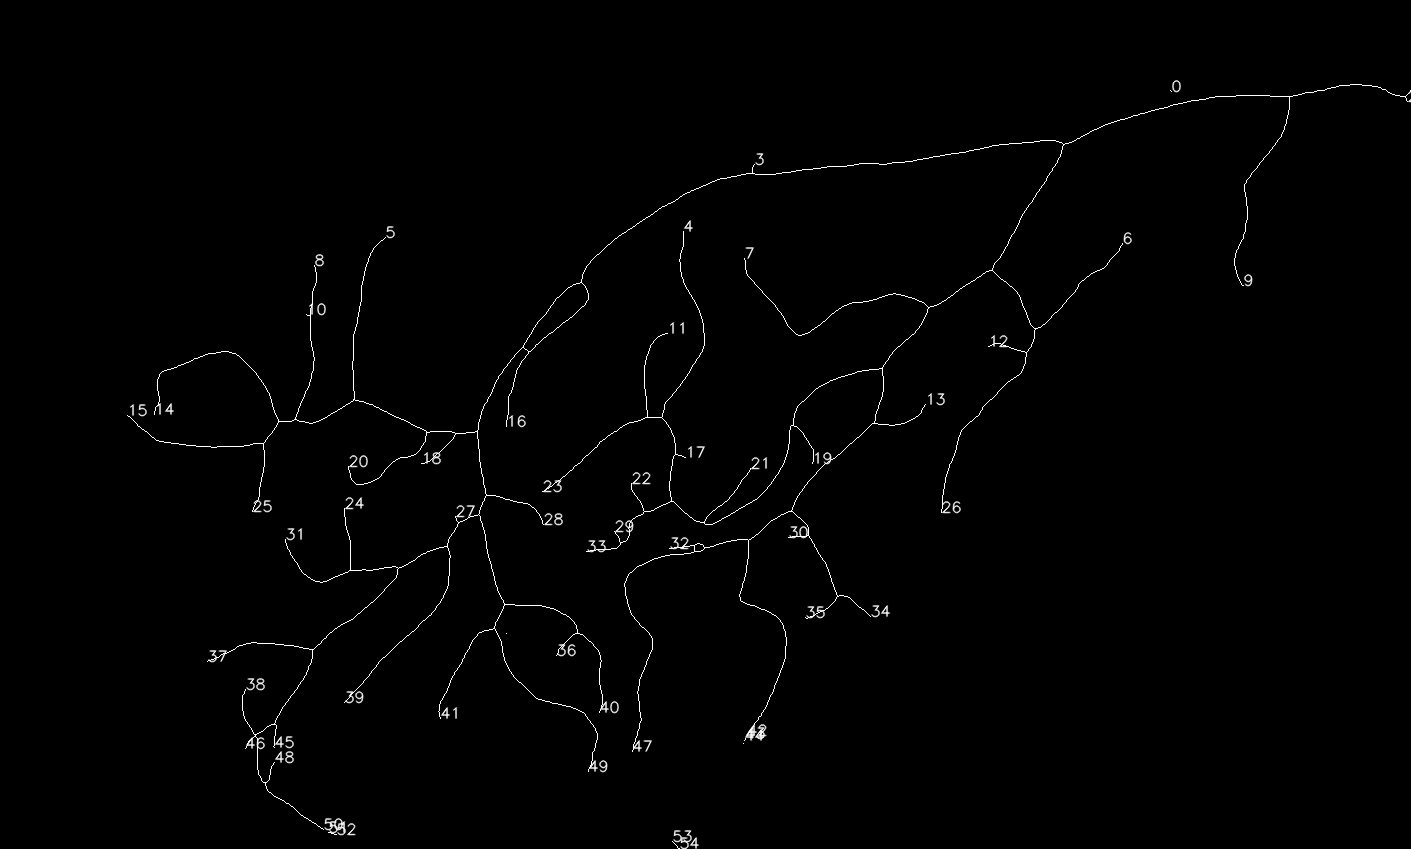

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [30]:
mark_nodes_on_skeleton(skeleton, clustered_junctions)
mark_nodes_on_skeleton(skeleton, clustered_leaf_nodes)

In [32]:
# Given all nodes on hand, we now track the edges and make a graph
# Note this appraoch leverages a simple DFS algorithm, which could be very computational expensive considering we have to trace the path pixel by pixel

def trace_path_dfs(skeleton, start, visited):

    visited.add(start)
    neighbors = find_neighbors(start, skeleton)
    neighbors = [n for n in neighbors if n not in visited]

    for neighbor in neighbors:
        if neighbor in all_nodes:
            return neighbor
        elif neighbor not in visited:
            result = trace_path_dfs(skeleton, neighbor, visited)
            if result:
                # If a node in 'all_nodes' is found in the recursion, return it
                return result

    # If no nodes in 'all_nodes' are found in any path, return None
    return None

In [33]:
import networkx as nx

G = nx.Graph()

all_nodes = set(clustered_junctions + clustered_leaf_nodes)
print("Num of all nodes:", len(all_nodes))

# Add all nodes to the graph
for node in all_nodes:
    G.add_node(node)

visited = set()
for node in all_nodes:
    if node not in visited:
        end_node = trace_path_dfs(skeleton, node, visited)
        # There was a discrepency between the number of pre-added nodes and the final number of nodes in the graph
        # It's possibly caused by the clustering process, in which we created nodes that didn't originally exist.
        # consistency check edges
        if end_node and end_node in all_nodes and end_node != node:
            G.add_edge(node, end_node)
        # Add the current node to visited set
        visited.add(node)


Num of all nodes: 104


In [34]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 104
Number of edges: 57


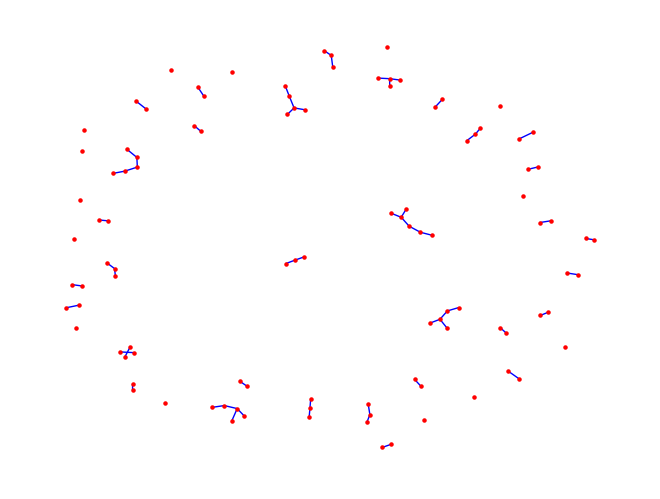

In [35]:
nx.draw(G, node_color='red', edge_color='blue', node_size=5, with_labels=False)

#### We could notice that there are so many disconnections between componenents. To inspect why this happens, we draw all edges on original skeleton.


In [36]:
# Draw all edges on the original skeleton

def draw_edges_on_skeleton(skeleton, graph):
    # Ensure skeleton is in the right format (255 for lines, 0 for background)
    marked_img = (skeleton * 255).astype('uint8')

    # Convert the image to BGR format since we're going to draw green lines
    marked_img = cv2.cvtColor(marked_img, cv2.COLOR_GRAY2BGR)

    # Draw each edge in the graph
    for edge in graph.edges():
        point1 = edge[0]
        point2 = edge[1]

        # Swap coordinates due to cv2
        point1 = (point1[1], point1[0])
        point2 = (point2[1], point2[0])

        cv2.line(marked_img, point1, point2, (0, 255, 0), 1)

    # Display the image
    cv2_imshow(marked_img)


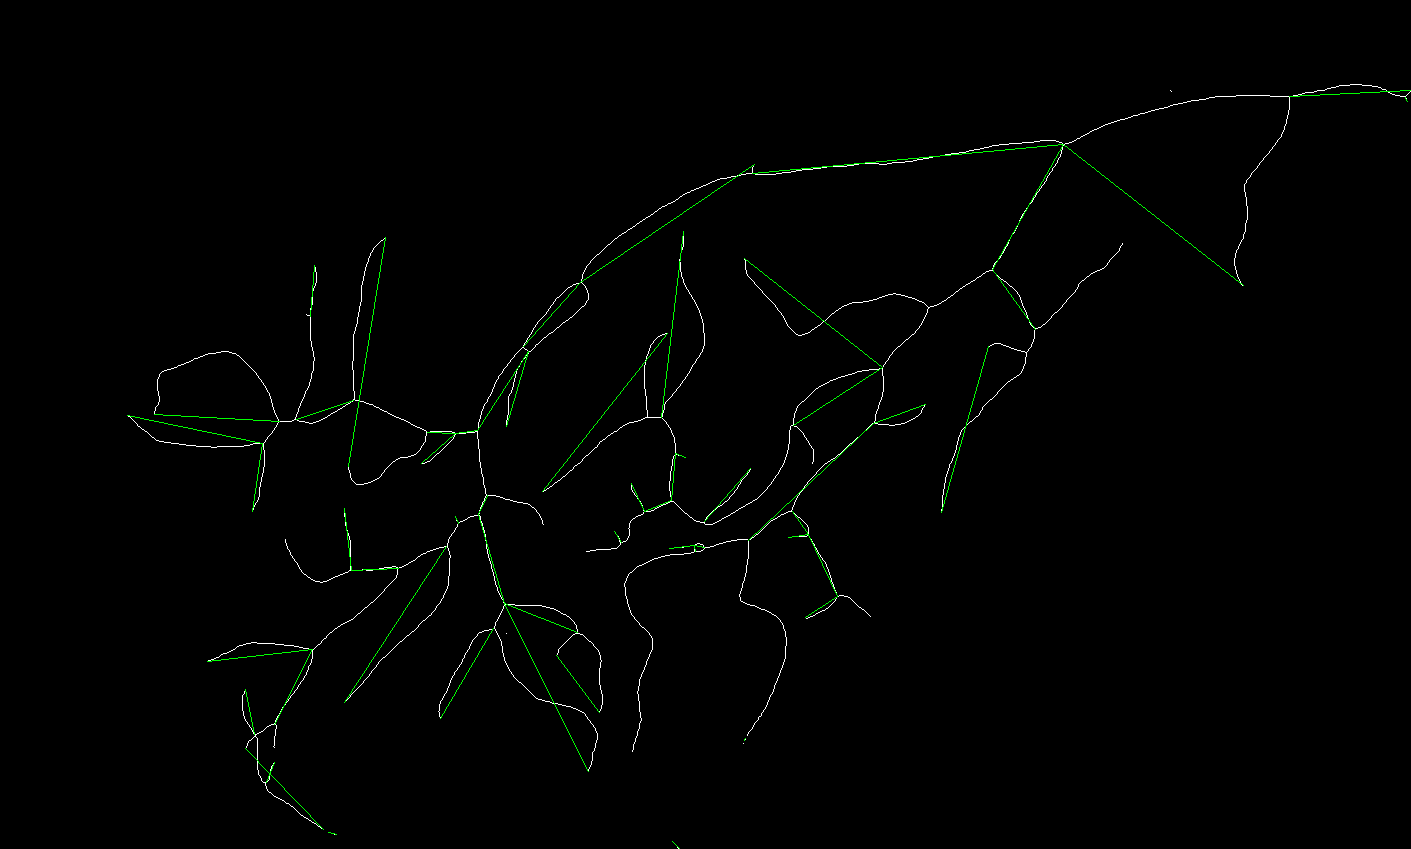

In [37]:
draw_edges_on_skeleton(skeleton, G)

In [200]:
# MAKE A MODIFIED TRACE PATH FUNCTION GIVEN THE INSPECTION RESULTS

def trace_path_dfs_modified(skeleton, start, visited, all_nodes, path):

    visited.add(start)
    path.append(start)

    connected_nodes = []
    neighbors = find_neighbors(start, skeleton)
    neighbors = [n for n in neighbors if n not in visited]

    if not neighbors:
        return []

    # Only edges between the node and nodes to whom they have direct connections can be added to the graph <--- THIS WILL BECOME A CONSTANT CHALLENGE IN LATER WORK
    for neighbor in neighbors:
        if neighbor in all_nodes:
            path.append(neighbor)
            if is_valid_path(skeleton, path, paths):
                paths.append(path.copy())
                connected_nodes.append(neighbor)
                break # BREAK THE LOOP ONCE A DESTINATION IS FOUND
        else:
            # find_neighbors will catch the node in all_nodes again
            # need visited for all_nodes
            connected_nodes.extend(trace_path_dfs_modified(skeleton, neighbor, visited, all_nodes, path))

        visited.add(neighbor)

    path.pop()

    return set(connected_nodes)



# ALSO CHECK IF IT SURPASSES OTHER NODES IN ALL_NODES.      <---- To counter the challenge that two nodes usually connect with each other if there's no direct edges in between
def is_valid_path(skeleton, path, paths, overlap_threshold=0.1):
    # Check if path is on the skeleton and not overlapping with nodes in all_nodes
    for i in range(1, len(path)-1):
        if not skeleton[path[i]]:
            return False
        if path[i] in all_nodes:
            return False

    # Check for overlap with existing paths
    for existing_path in paths:
        if get_overlap_percentage(path, existing_path) > overlap_threshold:
            return False

    return True

def get_overlap_percentage(path1, path2):
    set_path1 = set(path1)
    set_path2 = set(path2)
    overlap = set_path1.intersection(set_path2)
    if not set_path1 or not set_path2:
        return 0
    return len(overlap) / min(len(set_path1), len(set_path2))






In [225]:
# (285, 1243) FOR DEBUGGING PURPOSE

TEST_NODE = (285, 1243)

paths = [[(285, 1243), (285, 1242), (284, 1241), (283, 1241), (282, 1240), (281, 1240), (280, 1239), (279, 1239), (278, 1238), (277, 1238), (276, 1237), (275, 1237), (274, 1237), (273, 1236), (272, 1236), (271, 1236), (270, 1236), (269, 1235), (268, 1235), (267, 1235), (266, 1235), (265, 1234), (264, 1234), (263, 1234), (262, 1234), (261, 1234), (260, 1234), (259, 1234), (258, 1234), (257, 1235), (256, 1235), (255, 1235), (254, 1235), (253, 1235), (252, 1236), (251, 1236), (250, 1236), (249, 1237), (248, 1238), (247, 1238), (246, 1238), (245, 1239), (244, 1239), (243, 1240), (242, 1240), (241, 1241), (240, 1241), (239, 1242), (238, 1243), (237, 1243), (236, 1243), (235, 1243), (234, 1243), (233, 1244), (232, 1244), (231, 1245), (230, 1245), (229, 1245), (228, 1245), (227, 1245), (226, 1245), (225, 1245), (224, 1245), (223, 1245), (222, 1246), (221, 1246), (220, 1246), (219, 1247), (218, 1247), (217, 1247), (216, 1247), (215, 1247), (214, 1247), (213, 1247), (212, 1247), (211, 1247), (210, 1247), (209, 1247), (208, 1247), (207, 1247), (206, 1247), (205, 1246), (204, 1246), (203, 1246), (202, 1246), (201, 1246), (200, 1246), (199, 1246), (198, 1246), (197, 1246), (196, 1245), (195, 1245), (194, 1245), (193, 1245), (192, 1245), (191, 1244), (190, 1244), (189, 1244), (188, 1244), (187, 1244), (186, 1244), (185, 1244), (184, 1244), (183, 1245), (182, 1246), (181, 1246), (180, 1246), (179, 1247), (178, 1248), (177, 1249), (176, 1250), (175, 1250), (174, 1251), (173, 1251), (172, 1252), (171, 1253), (170, 1254), (169, 1255), (168, 1256), (167, 1257), (166, 1257), (165, 1258), (164, 1259), (163, 1259), (162, 1260), (161, 1261), (160, 1262), (159, 1263), (158, 1263), (157, 1264), (156, 1265), (155, 1266), (154, 1267), (153, 1268), (152, 1269), (151, 1269), (150, 1270), (149, 1271), (148, 1272), (147, 1272), (146, 1273), (145, 1274), (144, 1275), (143, 1275), (142, 1276), (141, 1277), (140, 1277), (139, 1278), (138, 1279), (137, 1280), (136, 1281), (135, 1281), (134, 1281), (133, 1282), (132, 1282), (131, 1283), (130, 1283), (129, 1284), (128, 1284), (127, 1284), (126, 1284), (125, 1285), (124, 1285), (123, 1286), (122, 1286), (121, 1286), (120, 1286), (119, 1286), (118, 1287), (117, 1287), (116, 1287), (115, 1287), (114, 1288), (113, 1288), (112, 1288), (111, 1288), (110, 1288), (109, 1289), (108, 1289), (107, 1289), (106, 1289), (105, 1289), (104, 1289), (103, 1289), (102, 1289), (101, 1289), (100, 1289), (99, 1289), (98, 1289), (97, 1289), (96, 1288), (96, 1287), (96, 1286), (96, 1285), (96, 1284), (96, 1283), (96, 1282), (96, 1281), (96, 1280), (96, 1279), (96, 1278), (96, 1277), (96, 1276), (96, 1275), (96, 1274), (96, 1273), (96, 1272), (96, 1271), (96, 1270), (95, 1269), (95, 1268), (95, 1267), (95, 1266), (95, 1265), (95, 1264), (95, 1263), (95, 1262), (95, 1261), (95, 1260), (95, 1259), (95, 1258), (95, 1257), (95, 1256), (95, 1255), (95, 1254), (95, 1253), (95, 1252), (95, 1251), (95, 1250), (95, 1249), (95, 1248), (95, 1247), (95, 1246), (95, 1245), (95, 1244), (95, 1243), (95, 1242), (95, 1241), (95, 1240), (95, 1239), (95, 1238), (95, 1237), (95, 1236), (96, 1235), (96, 1234), (96, 1233), (96, 1232), (96, 1231), (96, 1230), (96, 1229), (96, 1228), (96, 1227), (96, 1226), (96, 1225), (96, 1224), (96, 1223), (96, 1222), (96, 1221), (96, 1220), (96, 1219), (96, 1218), (96, 1217), (96, 1216), (96, 1215), (97, 1214), (97, 1213), (97, 1212), (97, 1211), (97, 1210), (97, 1209), (98, 1208), (98, 1207), (98, 1206), (99, 1205), (99, 1204), (99, 1203), (99, 1202), (99, 1201), (99, 1200), (99, 1199), (100, 1198), (100, 1197), (100, 1196), (100, 1195), (100, 1194), (100, 1193), (100, 1192), (100, 1191), (101, 1190), (101, 1189), (101, 1188), (101, 1187), (102, 1186), (102, 1185), (102, 1184), (102, 1183), (103, 1182), (103, 1181), (103, 1180), (103, 1179), (103, 1178), (104, 1177), (104, 1176), (104, 1175), (104, 1174), (104, 1173), (105, 1172), (105, 1171), (105, 1170), (106, 1169), (106, 1168), (107, 1167), (107, 1166), (107, 1165), (107, 1164), (108, 1163), (108, 1162), (108, 1161), (108, 1160), (108, 1159), (109, 1158), (109, 1157), (109, 1156), (109, 1155), (110, 1154), (110, 1153), (110, 1152), (110, 1151), (111, 1150), (111, 1149), (111, 1148), (112, 1147), (112, 1146), (112, 1145), (113, 1144), (113, 1143), (113, 1142), (113, 1141), (113, 1140), (114, 1139), (114, 1138), (115, 1137), (115, 1136), (115, 1135), (115, 1134), (115, 1133), (116, 1132), (116, 1131), (117, 1130), (117, 1129), (117, 1128), (118, 1127), (118, 1126), (118, 1125), (119, 1124), (119, 1123), (119, 1122), (119, 1121), (119, 1120), (120, 1119), (120, 1118), (120, 1117), (121, 1116), (121, 1115), (121, 1114), (122, 1113), (122, 1112), (122, 1111), (123, 1110), (123, 1109), (123, 1108), (124, 1107), (124, 1106), (124, 1105), (125, 1104), (125, 1103), (126, 1102), (126, 1101), (127, 1100), (127, 1099), (128, 1098), (128, 1097), (129, 1096), (129, 1095), (129, 1094), (130, 1093), (130, 1092), (131, 1091), (131, 1090), (132, 1089), (133, 1088), (133, 1087), (134, 1086), (134, 1085), (135, 1084), (135, 1083), (136, 1082), (136, 1081), (137, 1080), (138, 1079), (138, 1078), (138, 1077), (139, 1076), (140, 1075), (140, 1074), (141, 1073), (141, 1072), (142, 1071), (142, 1070), (142, 1069), (143, 1068), (143, 1067), (143, 1066), (143, 1065), (144, 1064), (144, 1063)]]


def draw_paths_on_skeleton(skeleton, paths, node):
    print("Input total", len(paths), "paths.")
    # Ensure skeleton is in the right format (255 for lines, 0 for background)
    marked_img = (skeleton * 255).astype('uint8')

    # Convert the image to BGR format since we're going to draw green lines
    marked_img = cv2.cvtColor(marked_img, cv2.COLOR_GRAY2BGR)

    x, y = node
    cv2.circle(marked_img, (y, x), 3, (255, 255, 255) , 3)

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
    radius = 1
    thickness = -1  # Negative thickness makes cv2.circle fill the circle

    for i, path in enumerate([paths[0]]):

      for x, y in path:
        cv2.circle(marked_img, (y, x), radius, colors[i%3], thickness)


    # Display the image
    cv2_imshow(marked_img)
    print(path)

Input total 1 paths.


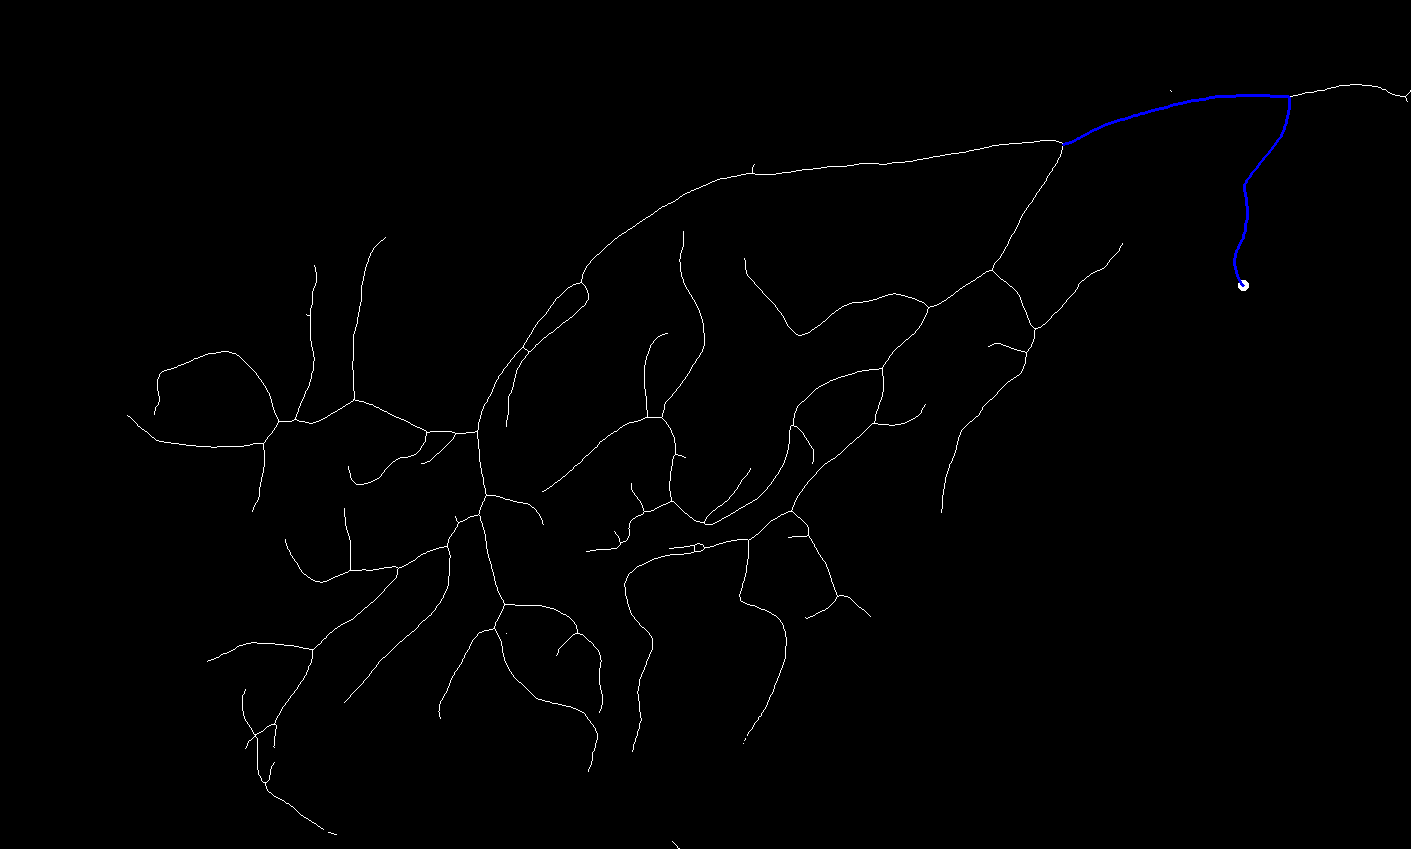

[(285, 1243), (285, 1242), (284, 1241), (283, 1241), (282, 1240), (281, 1240), (280, 1239), (279, 1239), (278, 1238), (277, 1238), (276, 1237), (275, 1237), (274, 1237), (273, 1236), (272, 1236), (271, 1236), (270, 1236), (269, 1235), (268, 1235), (267, 1235), (266, 1235), (265, 1234), (264, 1234), (263, 1234), (262, 1234), (261, 1234), (260, 1234), (259, 1234), (258, 1234), (257, 1235), (256, 1235), (255, 1235), (254, 1235), (253, 1235), (252, 1236), (251, 1236), (250, 1236), (249, 1237), (248, 1238), (247, 1238), (246, 1238), (245, 1239), (244, 1239), (243, 1240), (242, 1240), (241, 1241), (240, 1241), (239, 1242), (238, 1243), (237, 1243), (236, 1243), (235, 1243), (234, 1243), (233, 1244), (232, 1244), (231, 1245), (230, 1245), (229, 1245), (228, 1245), (227, 1245), (226, 1245), (225, 1245), (224, 1245), (223, 1245), (222, 1246), (221, 1246), (220, 1246), (219, 1247), (218, 1247), (217, 1247), (216, 1247), (215, 1247), (214, 1247), (213, 1247), (212, 1247), (211, 1247), (210, 1247)

In [226]:
draw_paths_on_skeleton(skeleton, paths, TEST_NODE)

#### Looks like detected paths were not as accurate as we expect. However, since we cannot guarantee pixel level accuracy, which is set in the skeletonization step and relies a lot on the skeletonization algorithm we use.

In [288]:
from collections import defaultdict

# REFRESH VISITED FOR EACH NODE

G_new = nx.Graph()

all_nodes = set(clustered_junctions + clustered_leaf_nodes)
# manual_adj_matrix = defaultdict(list)
print("Num of all nodes:", len(all_nodes))

# Add all nodes to the graph
for node in all_nodes:
    G_new.add_node(node)

# visited = set()
# i = 1
for node in all_nodes:
    visited = set() # refresh the visited for each node, each could possibily traverse the entire image
    path = []
    paths = []
    end_nodes = trace_path_dfs_modified(skeleton, node, visited, all_nodes, path)
    # print(i, len(paths), node, paths)
    # i += 1

    for end_node in end_nodes:
      # verify if the path is valid (the path is the length of activated pixels)
        if end_node != node:
            G_new.add_edge(node, end_node)
            # manual_adj_matrix[node].append(end_node)


Num of all nodes: 104


In [289]:
print("Number of nodes:", G_new.number_of_nodes())
print("Number of edges:", G_new.number_of_edges())

Number of nodes: 104
Number of edges: 111


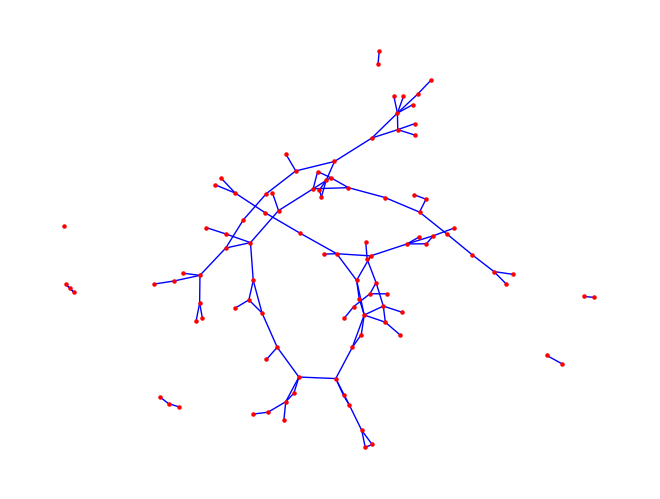

In [290]:
nx.draw(G_new, node_color='red', edge_color='blue', node_size=5, with_labels=False)

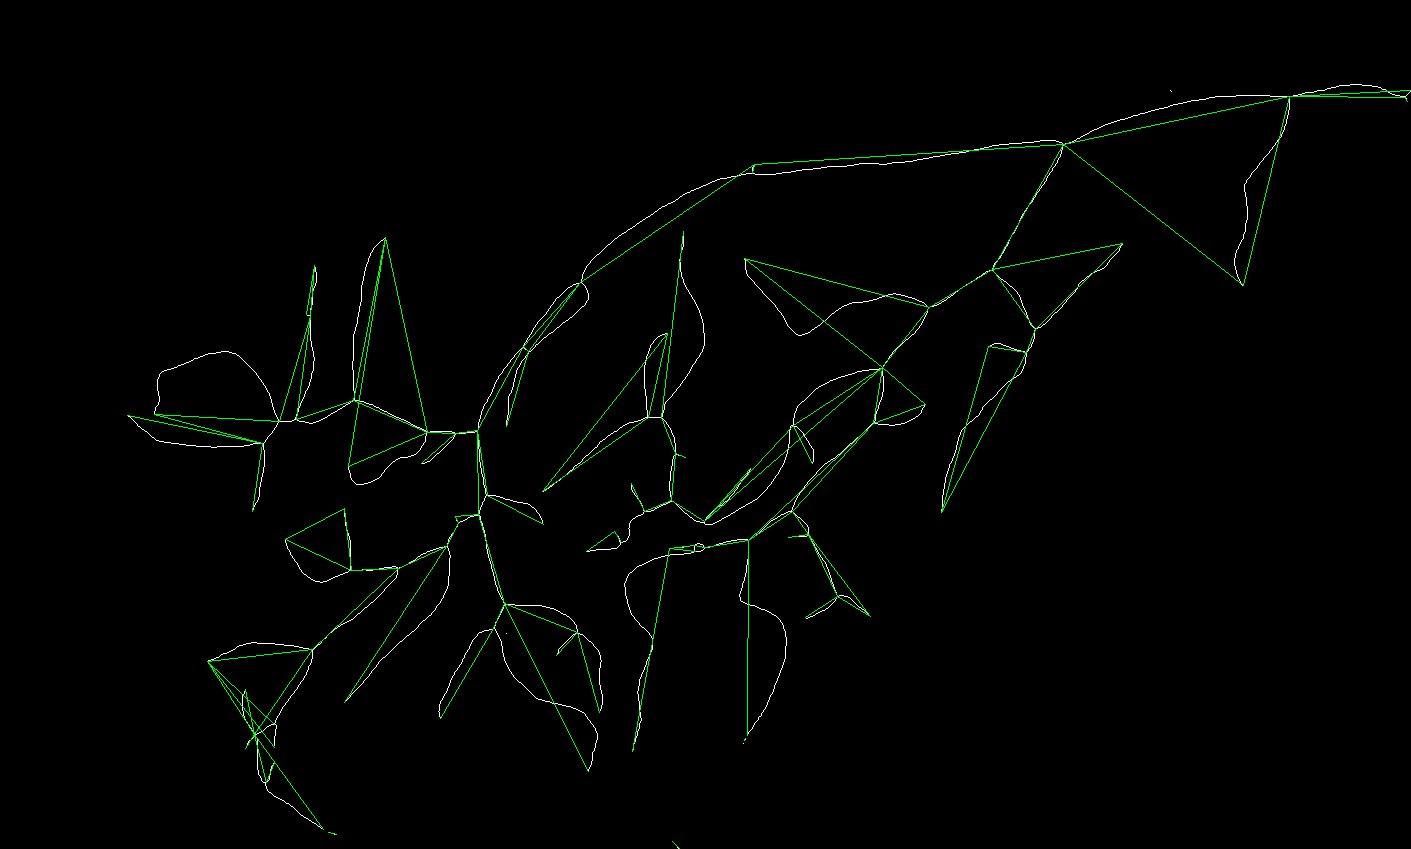

In [291]:
draw_edges_on_skeleton(skeleton, G_new)

#### We can note that it's still not perfect. Some nodes make connections with other nodes, which they don't have direct edges in between. Again, this could be resulted from errors from the skeletonization step, depending on what algorithms we use.

However, given the graph we have so far, we will run the count_leaves algorithm.

In [292]:
G_new.nodes

NodeView(((466, 348), (734, 254), (329, 1035), (421, 279), (346, 523), (521, 704), (568, 398), (738, 745), (548, 669), (468, 750), (426, 506), (483, 631), (661, 207), (617, 805), (316, 310), (457, 685), (512, 941), (834, 336), (417, 661), (596, 837), (425, 793), (551, 695), (616, 870), (285, 1243), (237, 385), (542, 621), (164, 754), (367, 882), (404, 925), (782, 266), (351, 528), (531, 614), (841, 672), (718, 440), (269, 992), (432, 427), (265, 314), (511, 644), (547, 704), (740, 744), (243, 1122), (173, 752), (771, 588), (90, 1410), (570, 351), (762, 274), (523, 458), (724, 274), (508, 344), (430, 477), (540, 748), (516, 455), (829, 323), (414, 154), (419, 296), (632, 577), (415, 127), (91, 1171), (747, 274), (352, 1026), (649, 312), (453, 675), (545, 694), (96, 1289), (500, 671), (748, 245), (346, 988), (628, 493), (314, 306), (333, 667), (417, 648), (144, 1063), (491, 542), (433, 455), (712, 599), (511, 792), (702, 344), (97, 1405), (832, 328), (495, 487), (463, 812), (534, 808), (

In [300]:
# Modify our original code, which only targeted a tree structure
# Makre sure we can handle ISOLATED components, we run count_leaves on each node.
# For an ideal neuronal dendrite, we may expect a simple tree structure - as the code in the beginning of the notebook demonstartes.

def count_leaves(G_new, node, visited=None):
    if visited is None:
        visited = set()

    if node in visited:
        return 0
    visited.add(node)

    if G_new.degree(node) == 1:
        return 1  # Return 1 for a leaf node but don't store it in the node's attributes

    leaf_count = sum(count_leaves(G_new, neighbor, visited) for neighbor in G_new.neighbors(node) if neighbor not in visited)

    # Store the total leaf count in the node attribute
    G_new.nodes[node]['leaf_number'] = leaf_count

    return leaf_count if leaf_count > 0 else 1

def process_all_nodes(G_new):
    for node in G_new.nodes():
        G_new.nodes[node]['leaf_number'] = 1
        count_leaves(G_new, node, visited=set())

In [301]:
process_all_nodes(G_new)

In [302]:
for node in G_new.nodes:
    print(f"Node {node} has {G_new.nodes[node]['leaf_number']} leaves")

# NOTE: THE ANSWER GIVEN BELOW IS NOT 100% ACCURATE, WHICH SHOULD BE IMPROVED BY OPTIMIZING THE SEGMENTATION AND SKELETONIZATION STEP.

Node (466, 348) has 3 leaves
Node (734, 254) has 4 leaves
Node (329, 1035) has 2 leaves
Node (421, 279) has 2 leaves
Node (346, 523) has 18 leaves
Node (521, 704) has 4 leaves
Node (568, 398) has 7 leaves
Node (738, 745) has 1 leaves
Node (548, 669) has 2 leaves
Node (468, 750) has 1 leaves
Node (426, 506) has 1 leaves
Node (483, 631) has 1 leaves
Node (661, 207) has 6 leaves
Node (617, 805) has 1 leaves
Node (316, 310) has 3 leaves
Node (457, 685) has 1 leaves
Node (512, 941) has 1 leaves
Node (834, 336) has 1 leaves
Node (417, 661) has 1 leaves
Node (596, 837) has 2 leaves
Node (425, 793) has 5 leaves
Node (551, 695) has 1 leaves
Node (616, 870) has 0 leaves
Node (285, 1243) has 2 leaves
Node (237, 385) has 3 leaves
Node (542, 621) has 1 leaves
Node (164, 754) has 19 leaves
Node (367, 882) has 11 leaves
Node (404, 925) has 6 leaves
Node (782, 266) has 1 leaves
Node (351, 528) has 1 leaves
Node (531, 614) has 2 leaves
Node (841, 672) has 1 leaves
Node (718, 440) has 1 leaves
Node (269